# Twitter Classification

Knowing the two most popular and neautral personalities; we wanted to base our Sentiment Analysis and deep learning model on their tweets.

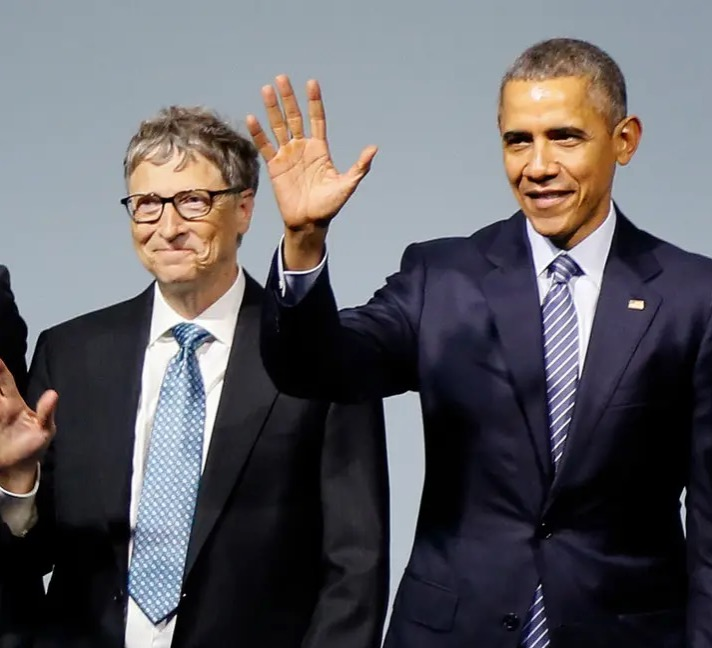

# Part I: Data Preparation

## Library Imports

In [ ]:
!pip install snscrape
import snscrape.modules.twitter as sntwitter
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import keras
from keras import preprocessing
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import pad_sequences

import tensorflow as tf
import os

import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 904 kB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Interest: 
* The two people of interest chosen are Bill Gates and Barack Obama. The reason is because I want to make sure that the tweet scraped vary in their sentiment. This ensures that we have a wide distribution of sentiment that I can use for modeling and increase the accuracy of the predictive model on sentiment values rather than working with skewed sentiment data.
* Bill Gates, tweets about a wide range of philanthropic issues that garner both positive and negative sentiment.
* Barack Obama, a political figure also tweets about a wide range of issues that consists of healthcare, elections, economic growth, etc...

## Scraping 1000 Tweets

## Directories

In [ ]:
# make a folder to store data
base_dir = '/content/'

#Create a new directory (a folder) in your Drive
tf.io.gfile.mkdir(base_dir)

#Combine the 2 strings
gates_dir = base_dir + 'Bill Gates/'

#Create the second directory
tf.io.gfile.mkdir(gates_dir)

In [ ]:
# make a folder to store data
base_dir = '/content/'

#Create a new directory (a folder) in your Drive
tf.io.gfile.mkdir(base_dir)

#Combine the 2 strings
obama_dir = base_dir + 'Barack Obama/'

#Create the second directory
tf.io.gfile.mkdir(obama_dir)

## Twitter API Search

In [ ]:
maxTweets = 1000
import time
startTime = time.time()

# Scraping Bill Gates Tweets
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@BillGates + since:2010-11-18 until:2022-11-30-filter:links -filter:replies').get_items()):
  csvFile = open(gates_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

maxTweets = 1000

# Scraping Barack Obama Tweets
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@BarackObama + since:2010-11-18 until:2022-11-30-filter:links -filter:replies').get_items()):
  csvFile = open(obama_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()


executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 44.336684703826904


In [ ]:
import glob

# Setting the file paths
files_gates = os.path.join("/content/Bill Gates", "*.csv")
files_obama = os.path.join("/content/Barack Obama", "*.csv")

# List of merged files returned
files_gates = glob.glob(files_gates)
files_obama = glob.glob(files_obama)

# Concatenating and Merging the Tweets into one dataset
df_gates= pd.concat(map(pd.read_csv, files_gates), ignore_index=True)
df_obama = pd.concat(map(pd.read_csv, files_obama), ignore_index=True)

tweets = [df_gates, df_obama]
df = pd.concat(tweets)

In [ ]:
df

,id,date,tweet
0,1567909364169863169,2022-09-08 16:14:57+00:00,Germany is a leading voice in the fight agains...
1,1594049106615291907,2022-11-19 19:24:57+00:00,In order to solve our world’s sanitation crisi...
2,1189326495900209152,2019-10-29 23:41:47+00:00,I always like to try out a new TV show or two ...
3,1400478260966744067,2021-06-03 15:43:31+00:00,Heroes like Dr. Mohamed Barrie are the reason ...
4,1537199676889235456,2022-06-15 22:25:37+00:00,I guess we finally ran out of microchips. http...
...,...,...,...
996,1384328303239106568,2021-04-20 02:09:21+00:00,Walter Mondale championed progressive causes a...
997,1001131488103030784,2018-05-28 16:02:01+00:00,We can never truly repay the debt we owe our f...
998,1580599805167796226,2022-10-13 16:42:14+00:00,Congrats to @JHUAPL on confirming we successfu...
999,791754307347492864,2016-10-27 21:31:51+00:00,Climate change is happening now. Denial is dan...


### Tweet Preprocessing: Lower Casing Tweets, Removing Special Characters, Removing Stop Words

In [ ]:
# Making tweets lowercase
df['tweet'] = df['tweet'].str.lower()
df.head()

,id,date,tweet
0,1567909364169863169,2022-09-08 16:14:57+00:00,germany is a leading voice in the fight agains...
1,1594049106615291907,2022-11-19 19:24:57+00:00,in order to solve our world’s sanitation crisi...
2,1189326495900209152,2019-10-29 23:41:47+00:00,i always like to try out a new tv show or two ...
3,1400478260966744067,2021-06-03 15:43:31+00:00,heroes like dr. mohamed barrie are the reason ...
4,1537199676889235456,2022-06-15 22:25:37+00:00,i guess we finally ran out of microchips. http...


In [ ]:
# Removing special characters from the tweets
df['tweet'] = df['tweet'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
df.head(10)

<ipython-input-8-2298282b37d4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()


,id,date,tweet
0,1567909364169863169,2022-09-08 16:14:57+00:00,germany is a leading voice in the fight agains...
1,1594049106615291907,2022-11-19 19:24:57+00:00,in order to solve our worlds sanitation crisis...
2,1189326495900209152,2019-10-29 23:41:47+00:00,i always like to try out a new tv show or two ...
3,1400478260966744067,2021-06-03 15:43:31+00:00,heroes like dr mohamed barrie are the reason w...
4,1537199676889235456,2022-06-15 22:25:37+00:00,i guess we finally ran out of microchips https...
5,1297219798925860864,2020-08-22 17:11:15+00:00,mosquito city is home to the worlds largest ca...
6,1545843628953649152,2022-07-09 18:53:36+00:00,if youre a big tennis fan like i am devisridha...
7,1318292960639774720,2020-10-19 20:48:29+00:00,its inspiring to see so much passion these day...
8,1161284341198217216,2019-08-13 14:32:17+00:00,melinda and i are big fans of donorschoose and...
9,1164507513708056578,2019-08-22 12:00:01+00:00,if we want to give our kids the best chance po...


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Removing stopwords from tweets
df["tweet"] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
df.head()

,id,date,tweet
0,1567909364169863169,2022-09-08 16:14:57+00:00,germany leading voice fight hiv tb malaria the...
1,1594049106615291907,2022-11-19 19:24:57+00:00,order solve worlds sanitation crisis need smar...
2,1189326495900209152,2019-10-29 23:41:47+00:00,always like try new tv show two im road watch ...
3,1400478260966744067,2021-06-03 15:43:31+00:00,heroes like dr mohamed barrie reason started f...
4,1537199676889235456,2022-06-15 22:25:37+00:00,guess finally ran microchips httpstcodptfyiglk


## Word Cloud

We can see that there are a variety of words that we could associate with the type of issues that Bill Gates and Barack Obama tweet about.

<Figure size 432x288 with 0 Axes>

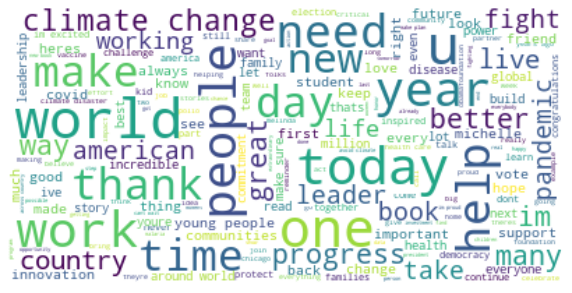

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(df['tweet']))

# lower max_font_size
wordcloud = WordCloud(background_color = 'white', max_font_size=40).generate(' '.join(df['tweet']))
plt.figure()
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## NLTK Sentiment Analyzer

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Adding Polarity Scores as Columns
df['compound_score'] = df['tweet'].map(lambda x: sid.polarity_scores(x)['compound'])
df['positive_score'] = df['tweet'].map(lambda x: sid.polarity_scores(x)['pos'])
df['negative_score'] = df['tweet'].map(lambda x: sid.polarity_scores(x)['neg'])
df['neutral_score' ] = df['tweet'].map(lambda x: sid.polarity_scores(x)['neu'])

df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,id,date,tweet,compound_score,positive_score,negative_score,neutral_score
0,1567909364169863169,2022-09-08 16:14:57+00:00,germany leading voice fight hiv tb malaria the...,0.7096,0.314,0.096,0.590
1,1594049106615291907,2022-11-19 19:24:57+00:00,order solve worlds sanitation crisis need smar...,-0.0516,0.257,0.178,0.565
2,1189326495900209152,2019-10-29 23:41:47+00:00,always like try new tv show two im road watch ...,0.3612,0.135,0.000,0.865
3,1400478260966744067,2021-06-03 15:43:31+00:00,heroes like dr mohamed barrie reason started f...,0.9371,0.463,0.000,0.537
4,1537199676889235456,2022-06-15 22:25:37+00:00,guess finally ran microchips httpstcodptfyiglk,0.0000,0.000,0.000,1.000
...,...,...,...,...,...,...,...
996,1384328303239106568,2021-04-20 02:09:21+00:00,walter mondale championed progressive causes c...,0.5719,0.144,0.000,0.856
997,1001131488103030784,2018-05-28 16:02:01+00:00,never truly repay debt owe fallen heroes remem...,0.9288,0.484,0.121,0.395
998,1580599805167796226,2022-10-13 16:42:14+00:00,congratsto jhuapl confirming successfully move...,-0.3400,0.107,0.188,0.705
999,791754307347492864,2016-10-27 21:31:51+00:00,climate change happening denial dangerous http...,-0.4767,0.000,0.383,0.617


## Distribution of the Sentiment Scores 

<ipython-input-13-b7ab4a0d98ab>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax)


,compound_score,positive_score,negative_score,neutral_score
count,2002.000000,2002.000000,2002.000000,2002.000000
mean,0.479958,0.281049,0.066285,0.652659
std,0.449854,0.163461,0.100904,0.161707
min,-0.934900,0.000000,0.000000,0.199000
25%,0.226300,0.171000,0.000000,0.543000
50%,0.636900,0.281000,0.000000,0.646000
75%,0.831600,0.396000,0.114000,0.752750
max,0.981900,0.801000,0.787000,1.000000


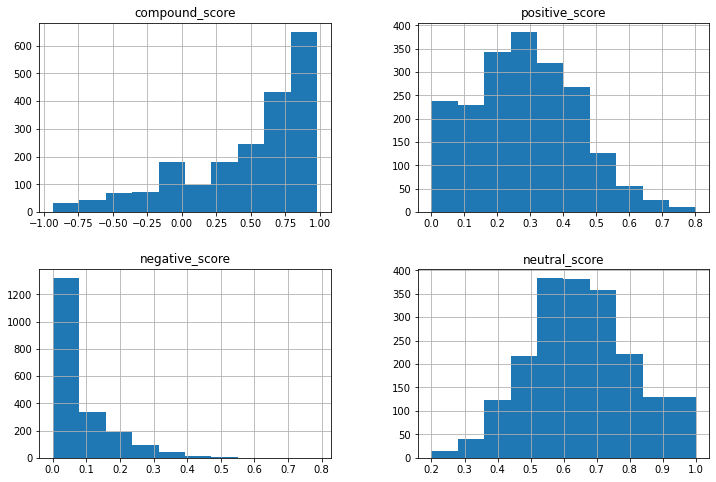

In [ ]:
fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df.hist(ax = ax)

df.describe()

* **Compound Scores:** Distribution is positively skewed since the mean is 0.48 however since it's not extreme positivity, we can accept this distribution of sentiment.

* **Positive Scores:** There is a healthy distribution of positive scores ranging from 0 - 0.8, with the data distribution slightly right skewed.

* **Negative Scores:** The distribution is extremely right skewed indicating that most of the tweets did not contain large amounts of text perceived as negative. 

* **Neutral Scores:** Score distribution is spread out with mean of 0.65. 

# Part II: Modeling

## Model 1

CountVectorizer() and TF-IDF with a Dense Neural Network


In [ ]:
X = df['tweet']
y = df[['compound_score','positive_score','negative_score','neutral_score']]
print(X.shape, y.shape)

(2002,) (2002, 4)


In [ ]:
# Fitting CountVectorizer using the Keras Tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X)

print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)

OrderedDict([('germany', 4), ('leading', 19), ('voice', 23), ('fight', 100), ('hiv', 8), ('tb', 11), ('malaria', 39), ('theyre', 35), ('stepping', 6), ('increasing', 5), ('pledge', 8), ('globalfund', 17), ('germanys', 1), ('commitment', 44), ('fightforwhatcounts', 3), ('help', 192), ('save', 37), ('millions', 45), ('lives', 102), ('httpstcovjmuudzzc', 1), ('order', 8), ('solve', 13), ('worlds', 43), ('sanitation', 7), ('crisis', 21), ('need', 134), ('smarter', 2), ('toilets', 6), ('dont', 41), ('rely', 2), ('sewage', 1), ('systems', 10), ('prevent', 35), ('spread', 12), ('diseases', 26), ('worldtoiletday', 3), ('httpstcogbpfgxle', 1), ('always', 85), ('like', 145), ('try', 10), ('new', 162), ('tv', 2), ('show', 26), ('two', 44), ('im', 276), ('road', 7), ('watch', 23), ('next', 108), ('set', 22), ('ask', 16), ('likewise', 7), ('collect', 2), ('recommendations', 4), ('httpstcoknumwyo', 1), ('heroes', 19), ('dr', 30), ('mohamed', 1), ('barrie', 1), ('reason', 7), ('started', 28), ('found

In [ ]:
# Integer Encoding the Documents using TFIDF
encoded_docs = t.texts_to_matrix(X, mode='tfidf') 
print(encoded_docs)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.13984583 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 6.90975328 0.         0.        ]
 [0.         0.         0.         ... 0.         6.90975328 6.90975328]]


### Splitting the documents into Train (70%) and Test (30%) partitions

In [ ]:
# Splitting into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y,
                                                    train_size=0.7)
print(encoded_docs.shape) # original TFIDF
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2002, 8564)
(1401, 8564) (1401, 4)
(601, 8564) (601, 4)


### Fitting the Model

In [ ]:
# Setting the input of the last dense layer 
n_outputs = y.shape[1]
print(n_outputs)

4


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs)) # Default activation function of linear
model.summary()

model.compile(optimizer='adam',
              loss='mae',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                548160    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 550,372
Trainable params: 550,372
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import keras
from keras.callbacks import EarlyStopping


es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=20,
                    validation_split=0.2
                    ) 

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 0.3917 - acc: 0.3045 - val_loss: 0.2591 - val_acc: 0.4911
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3124 - acc: 0.4393 - val_loss: 0.2481 - val_acc: 0.5338
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 0.2802 - acc: 0.4911 - val_loss: 0.2513 - val_acc: 0.5623
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 0.2601 - acc: 0.5161 - val_loss: 0.2441 - val_acc: 0.5730
Epoch 5/20
56/56 [==============================] - 1s 13ms/step - loss: 0.2411 - acc: 0.5429 - val_loss: 0.2401 - val_acc: 0.5623
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 0.2234 - acc: 0.5509 - val_loss: 0.2298 - val_acc: 0.5658
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 0.2125 - acc: 0.5545 - val_loss: 0.2187 - val_acc: 0.5374
Epoch 8/20
56/56 [==============================] - 1s 15ms/step - loss: 0.1946 - a

In [ ]:
# Dictionary of model metrics
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### Learning Curve

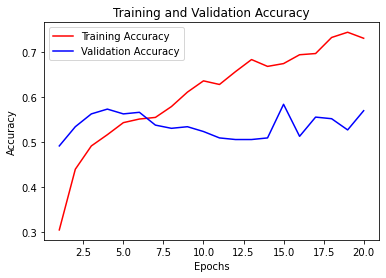

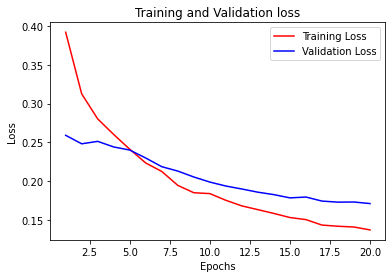

In [ ]:
# learning curve
import matplotlib.pyplot as plt

# accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'r', label='Training Accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


plt.plot(epochs, loss, 'r', label='Training Loss')

plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

* Training Accuracy did not learn smoothly but did improve significantly. Validation Accuracy however failed to improve at the same rate as the training set and stayed stagnant. 

* Training Loss and Validation Loss decreased overall where the training set started to gradually decrease after the 5th epoch while the validation set gradually decreased from the initial epoch. 

### Scatterplot of Actual vs. Predicted

19/19 [==============================] - 0s 4ms/step


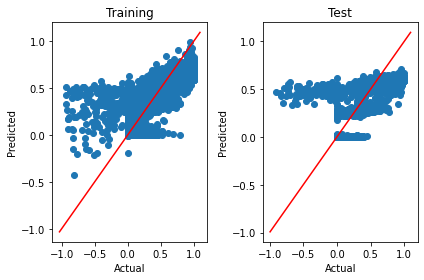

In [ ]:
# scatterplot of actual vs. pred

fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")

# adding 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")

# adding 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')


fig.tight_layout()

# show the plot
plt.show()

### Model 1 Metrics

In [ ]:
preds = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print('Model 1 MAE: ', round(mean_absolute_error(y_test, preds),4))

from sklearn.metrics import mean_squared_error
print('Model 1 MSE: ', round(mean_squared_error(y_test, preds),4))

import math
print('Model 1 RMSE: ', round(math.sqrt(mean_squared_error(y_test, preds)),4))

score = model.evaluate(X_test, y_test, verbose = 0) 
print('Model 1 Accuracy:', round(score[1],4))

19/19 [==============================] - 0s 4ms/step
Model 1 MAE:  0.1633
Model 1 MSE:  0.0605
Model 1 RMSE:  0.2459
Model 1 Accuracy: 0.6073


The first model achieved low MAE and MSE values but achieved 60.73% accuracy.

## Model 2
Flattened word embeddings into a pre-trained Dense Neural Network

In [ ]:
texts = df['tweet']
labels = df[['compound_score','positive_score','negative_score','neutral_score']]

In [ ]:
maxlen = 250  # We will cut tweets after 250 words
training_samples = 1400  # We will be training on 1400 samples
test_samples = 600  # We will using 600 samples for testing 
max_words = 2000 # We will only consider the top 2,000 words in the dataset

### Tokenizing the text

In [ ]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

# Converted our target variable list to a numpy array for modeling
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 8563 unique tokens.
Shape of data tensor: (2002, 250)
Shape of label tensor: (2002, 4)


In [ ]:
# Shuffling the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Assigning train and test partitions based on a 70/30 split 
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_test = data[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]

### Loading Pre-Trained Embeddings

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1pgel9SHcmN7-Mjky_36-yswuxAFcRpNn
glove_file = '/content/glove.6B.100d.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1pgel9SHcmN7-Mjky_36-yswuxAFcRpNn
To: /content/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 230MB/s]


#### Pre-trained Directory

In [ ]:
glove_dir = '/content'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Building the Embedding Matrix

In [ ]:
embedding_dim = 100 # dimension of the imported embeddings


embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Model Architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          200000    
                                                                 
 flatten (Flatten)           (None, 25000)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1600064   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [ ]:
# Restricting Training on the first layer and setting the weights 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Fitting the Model with the GloVe Embeddings

In [ ]:
from keras.callbacks import EarlyStopping


es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=50,
                                   restore_best_weights=True)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=[es],
                    batch_size=20,
                    validation_split=0.2)
# saving the model to local directory
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/100
56/56 [==============================] - 2s 26ms/step - loss: 0.1602 - acc: 0.4420 - val_loss: 0.1008 - val_acc: 0.5143
Epoch 2/100
56/56 [==============================] - 1s 26ms/step - loss: 0.1239 - acc: 0.4795 - val_loss: 0.0907 - val_acc: 0.5143
Epoch 3/100
56/56 [==============================] - 2s 27ms/step - loss: 0.1006 - acc: 0.5089 - val_loss: 0.0744 - val_acc: 0.5143
Epoch 4/100
56/56 [==============================] - 2s 27ms/step - loss: 0.0863 - acc: 0.5312 - val_loss: 0.0735 - val_acc: 0.5143
Epoch 5/100
56/56 [==============================] - 1s 26ms/step - loss: 0.0755 - acc: 0.5420 - val_loss: 0.0696 - val_acc: 0.5143
Epoch 6/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0726 - acc: 0.5455 - val_loss: 0.0697 - val_acc: 0.5143
Epoch 7/100
56/56 [==============================] - 2s 31ms/step - loss: 0.0700 - acc: 0.5661 - val_loss: 0.0688 - val_acc: 0.5179
Epoch 8/100
56/56 [==============================] - 1s 25ms/step - loss: 0.

In [ ]:
# Dictionary of model metrics
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### Learning Curves

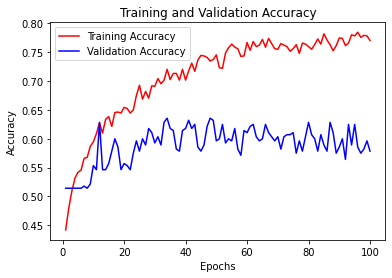

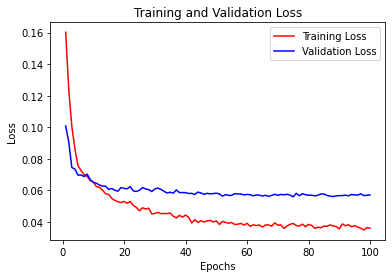

In [ ]:
# learning curve
import matplotlib.pyplot as plt

# accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'r', label='Training Accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# "r" is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training Loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training Accuracy continued to increase throughout the learning process while validation accuracy stagnated and only remained in a range of 0.55 to 0.65 but peaked early on near the 15th epoch. 

Training and Validation Loss were more similar than accuracy where training loss started higher but lowered quickly through training but validation remained relatively the same after the 10th epoch.

### Scatterplot of Actual vs. Predicted

19/19 [==============================] - 0s 6ms/step


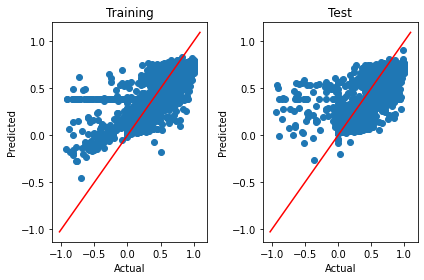

In [ ]:
# scatterplot of actual vs. pred

fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# adding 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
# adding 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

### Metrics

In [ ]:
preds = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print('Model 2 MAE: ', round(mean_absolute_error(y_test, preds),4))

from sklearn.metrics import mean_squared_error
print('Model 2 MSE: ', round(mean_squared_error(y_test, preds),4))

import math
print('Model 2 RMSE: ', round(math.sqrt(mean_squared_error(y_test, preds)),4))

score = model.evaluate(X_test, y_test, verbose = 0) 
print('Model 2 Accuracy:', round(score[1],6))

19/19 [==============================] - 0s 6ms/step
Model 2 MAE:  0.1542
Model 2 MSE:  0.0509
Model 2 RMSE:  0.2257
Model 2 Accuracy: 0.611667


Model 2 results in significantly higher accuracy scores using pre-trained embeddings in the training set and validation set compared to Model 1's accuracy results. 

## Model 3

Recurrent Neural Network with LSTM and GRU


In [ ]:
max_features = 5000  # number of words to consider as features
maxlen = 250  # cut texts after this number of words 
batch_size = 50

### Fitting the Model

In [ ]:
from keras.layers import Dense, LSTM, Dropout, GRU, Embedding, SimpleRNN, Conv1D, MaxPooling1D, Bidirectional, GRU
from keras.models import Sequential

from keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU
# define model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(30,
                            return_sequences=True,
                            activation='relu',
                            recurrent_dropout=0.2)))
model.add(GRU(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 124, 64)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 124, 60)          22800     
 nal)                                                            
                                                                 
 gru_1 (GRU)                 (None, 20)                4920      
                                                                 
 dropout_5 (Dropout)         (None, 20)               

### Model Compile and Fitting the Model

In [ ]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=['acc'])

es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=20,
                    callbacks=[es],
                    validation_split=0.2)

Epoch 1/20
56/56 [==============================] - 24s 262ms/step - loss: 0.2550 - acc: 0.3714 - val_loss: 0.1731 - val_acc: 0.5321
Epoch 2/20
56/56 [==============================] - 12s 217ms/step - loss: 0.1703 - acc: 0.6857 - val_loss: 0.1573 - val_acc: 0.6786
Epoch 3/20
56/56 [==============================] - 15s 265ms/step - loss: 0.1438 - acc: 0.7750 - val_loss: 0.1470 - val_acc: 0.7000
Epoch 4/20
56/56 [==============================] - 15s 267ms/step - loss: 0.1209 - acc: 0.8545 - val_loss: 0.1420 - val_acc: 0.7071
Epoch 5/20
56/56 [==============================] - 15s 267ms/step - loss: 0.1051 - acc: 0.8670 - val_loss: 0.1395 - val_acc: 0.6893
Epoch 6/20
56/56 [==============================] - 15s 277ms/step - loss: 0.0942 - acc: 0.8705 - val_loss: 0.1364 - val_acc: 0.6964
Epoch 7/20
56/56 [==============================] - 15s 266ms/step - loss: 0.0824 - acc: 0.8741 - val_loss: 0.1352 - val_acc: 0.7250
Epoch 8/20
56/56 [==============================] - 17s 299ms/step - 

### Learning Curves

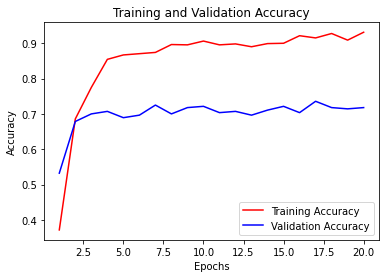

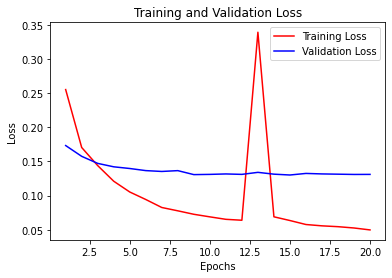

In [ ]:
# learning curve
import matplotlib.pyplot as plt

# accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'r', label='Training Accuracy')

plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


plt.plot(epochs, loss, 'r', label='Training Loss')

plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and Validation Accuracy are extremely similar and show trends of the similar spikes of increases and decreases but accuracy does not improve past the 2nd epoch for the trainin set. 

Training and Validation Loss had wildly varying values where the training set loss values spiked significantly but normalized and the validation set was consistent in the 0.5 to 0.65 range. 

### Scatterplot of Actual vs. Predicted

19/19 [==============================] - 1s 62ms/step


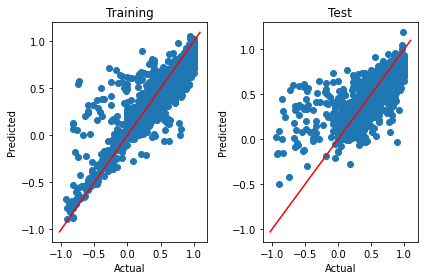

In [ ]:
# scatterplot of actual vs. pred
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")

# adding 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Test Results
axes[1].scatter(x=y_test, y=model.predict(X_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")

# adding 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')


fig.tight_layout()
plt.show()

### Metrics

In [ ]:
preds = model.predict(X_test)
from sklearn.metrics import mean_absolute_error
print('Model 3 MAE: ', round(mean_absolute_error(y_test, preds),4))

from sklearn.metrics import mean_squared_error
print('Model 3 MSE: ', round(mean_squared_error(y_test, preds),4))

import math
print('Model 3 RMSE: ', round(math.sqrt(mean_squared_error(y_test, preds)),4))

score = model.evaluate(X_test, y_test, verbose = 0) 
print('Model 3 Accuracy:', round(score[1],6))

19/19 [==============================] - 1s 59ms/step
Model 3 MAE:  0.1204
Model 3 MSE:  0.0363
Model 3 RMSE:  0.1904
Model 3 Accuracy: 0.763333


Model 3 accuracy results of 76.3% which is an improvement from earlier models. 

# Part III: Analysis

* The first model was frequency based therefore had lesser context in terms of information when compared to the second model which used text embedding technique for text analysis.
* The third model worked better i.e., has improved accuracy compared to Model 1 and Model 2 since stacked layers in Model 3 are being used. 
* We tweaked the number of words for model input to improve our model.
* Rule based systems like NLTK sentiment analysis will not provide context and only work on the pre defined rules. However, our deep learning models will perform superior if we do not use nltk library. 
*To improve the performance of the second model, I started by specifying lower amounts of text to consider in the dataset. We also slowed down the learning rate and increased the amount of patience so that the model would be able to learn incorporate the embedding weights. Increasing the glove dimensions performed worse on the model since we only trained on 2000 words.
* There are a lot of hyperparameters that can be tuned to make changes to our model for better fitting and accuracy. 